Mounted at /content/drive

               CREDIT CARD ML PIPELINE - GOOGLE COLAB

[1] LOADING DATA FROM GOOGLE DRIVE...
✓ Dataset loaded: 7298 rows, 14 columns

Dataset Overview:
  - Memory usage: 3.19 MB
  - Missing values: 0
  - Duplicate rows: 0

First few rows:
   CLIENTNUM Attrition_Flag  Customer_Age  Gender  Dependent_count  \
0  708082083             no            45  female                3   
1  708084558            yes            46    male                3   
2  708085458             no            34  female                2   
3  708098133             no            32  female                0   
4  708099183             no            37  female                2   

  Education_Level               Marital_Status Income_Category Card_Category  \
0       secondary  married/living with partner            <30k          blue   
1     third level                     divorced       71 – 110k          blue   
2         primary                       single            <30k          b

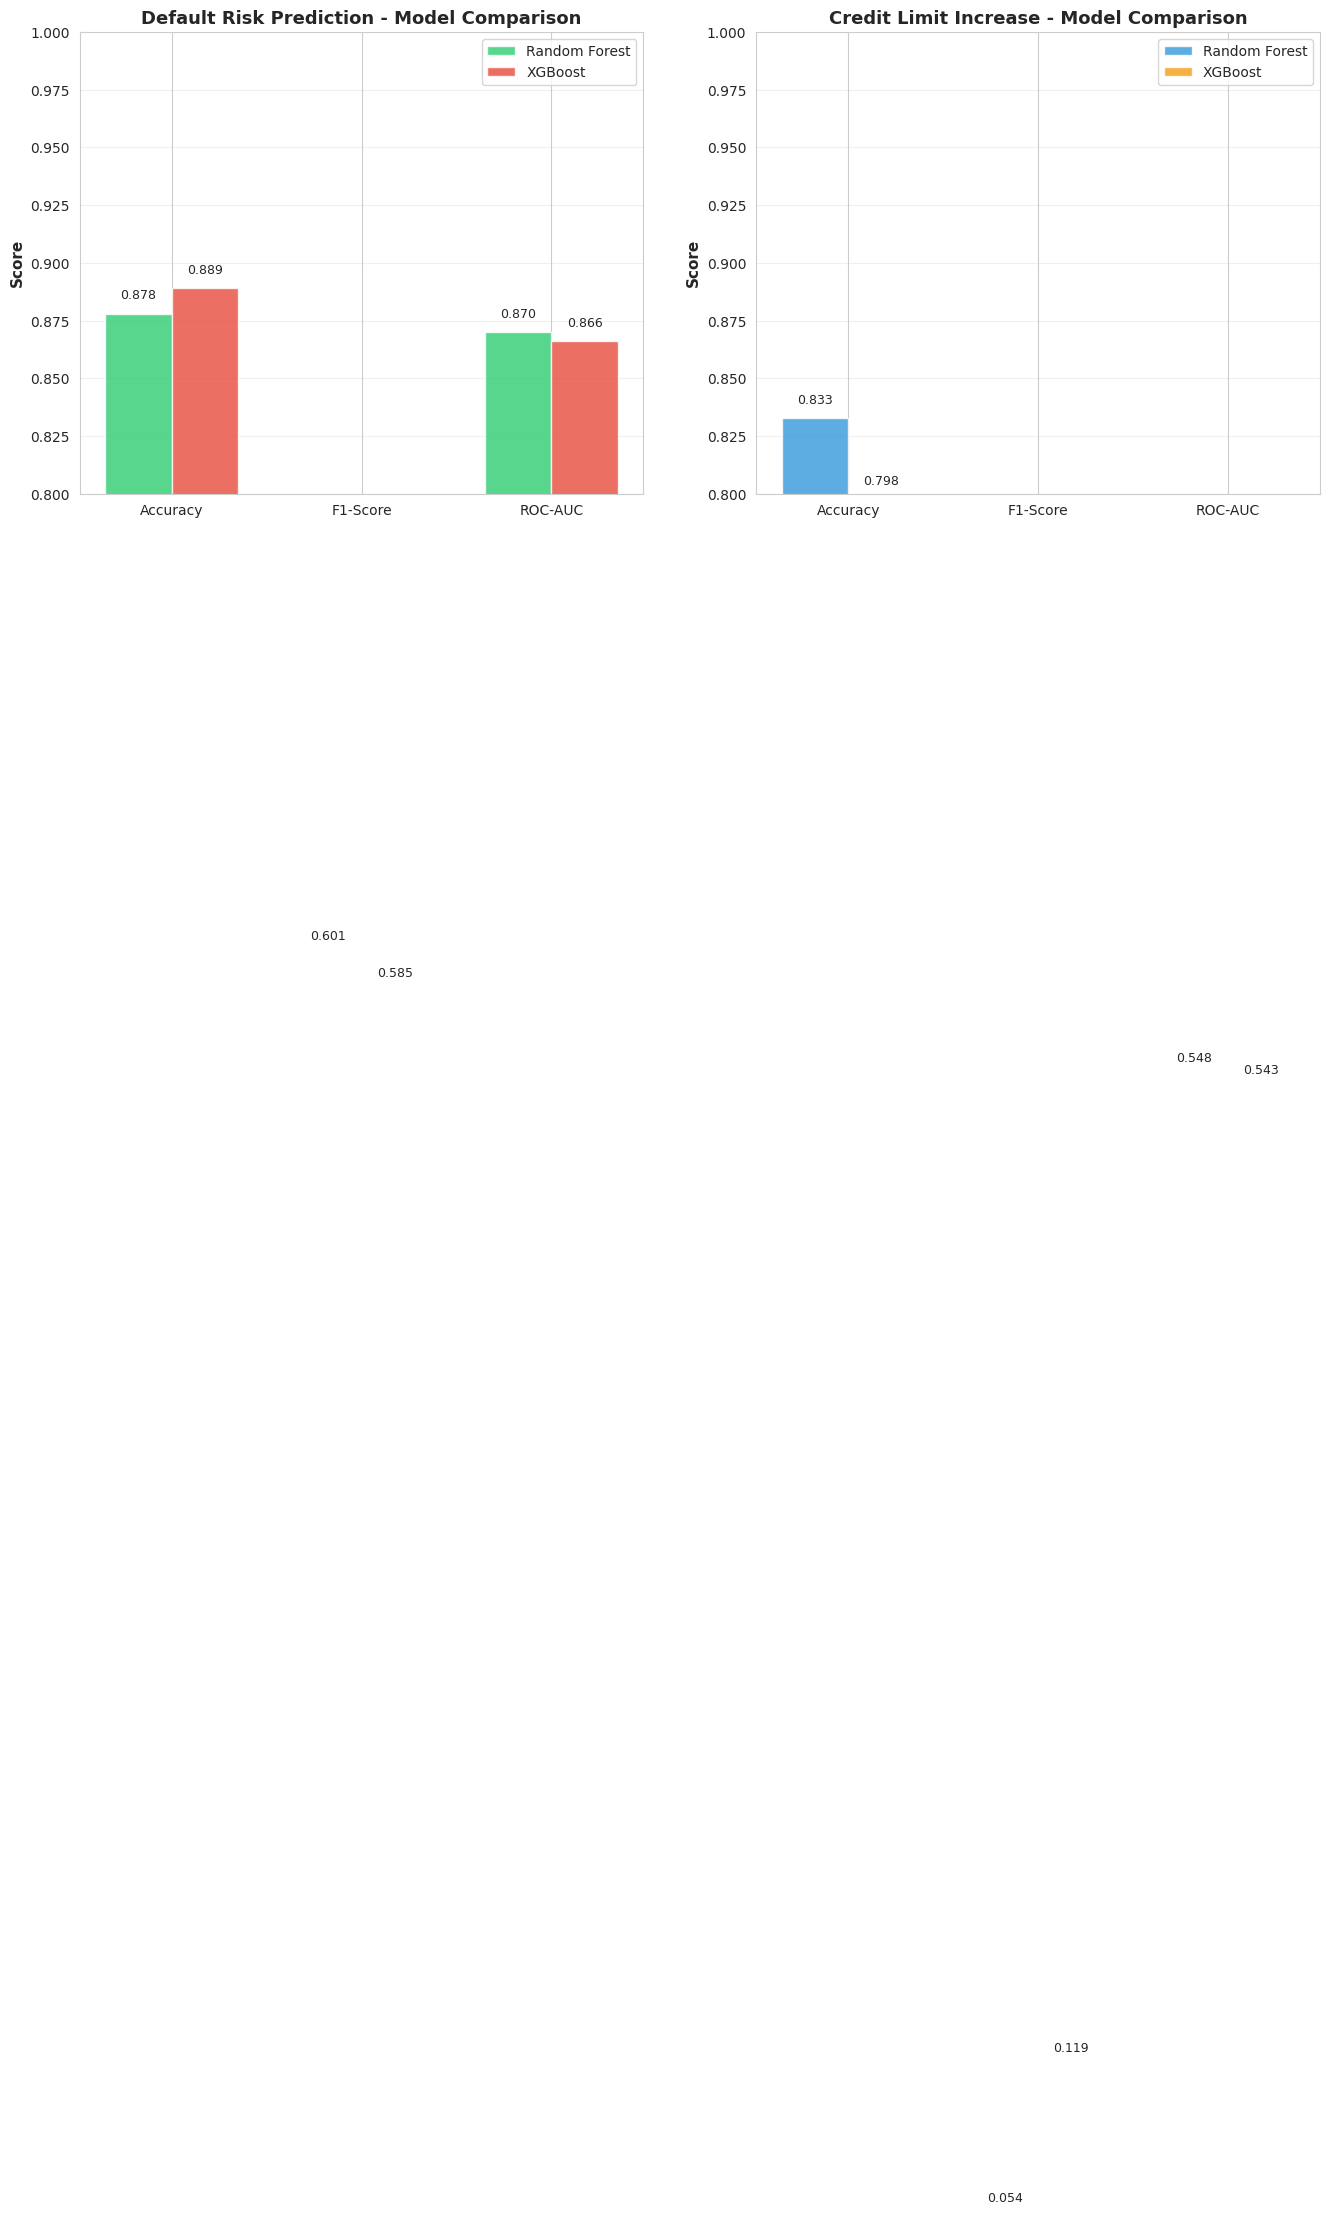

✓ Saved: 02_Confusion_Matrices.png


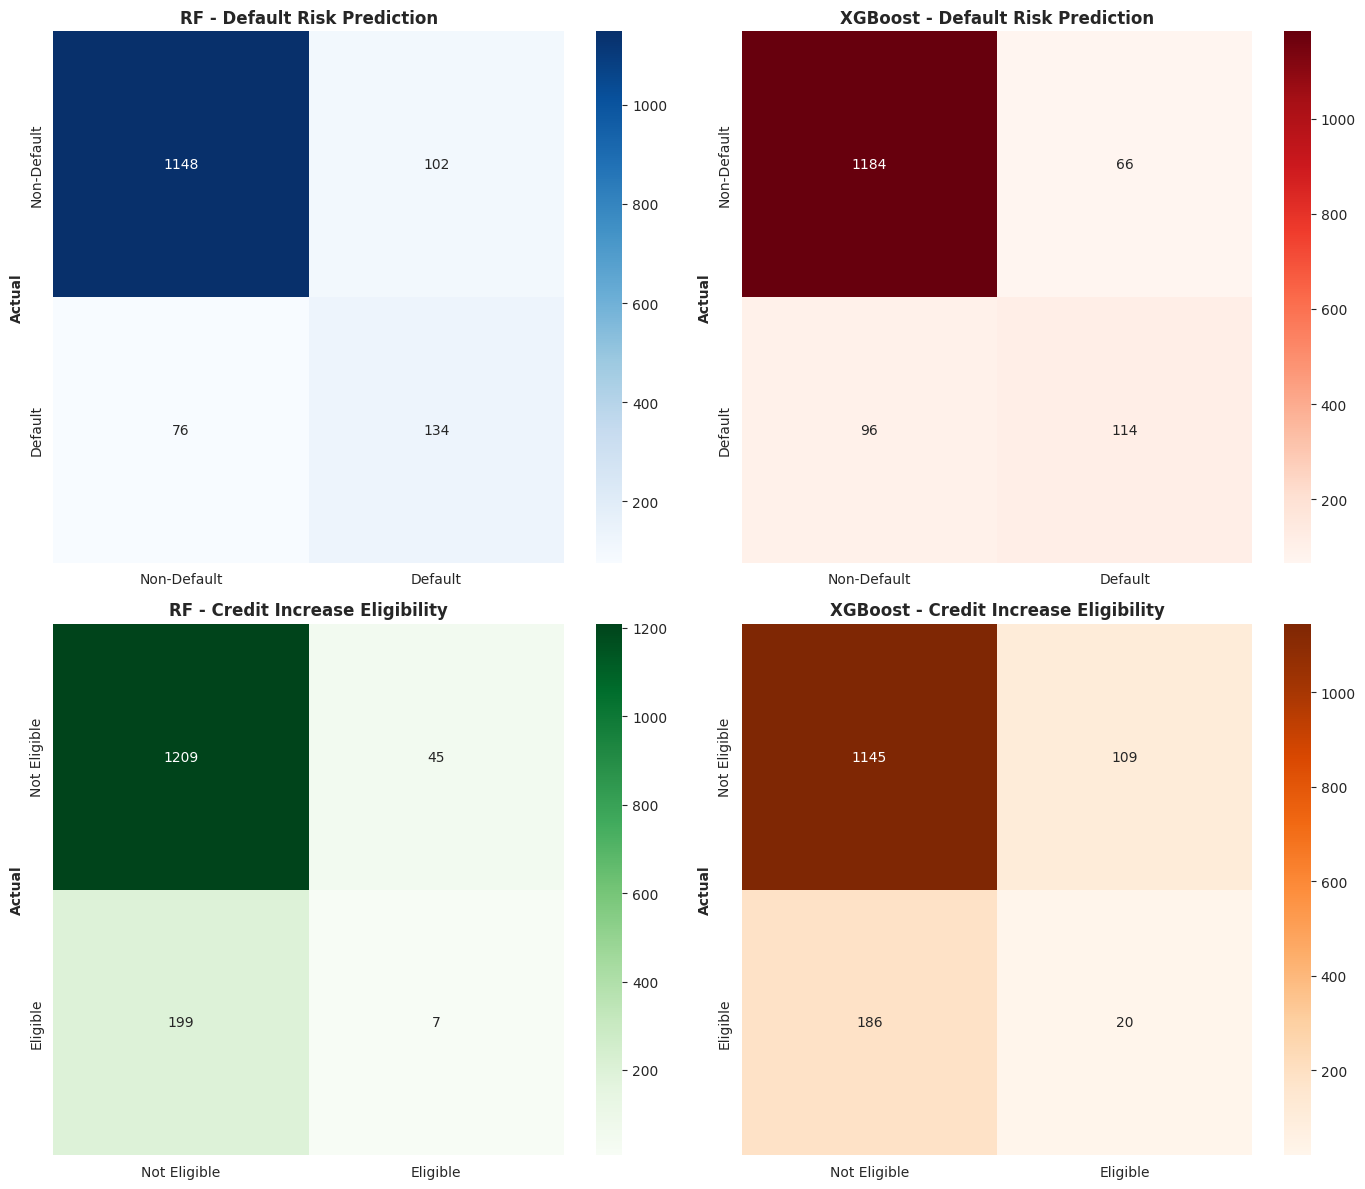

✓ Saved: 03_ROC_Curves.png


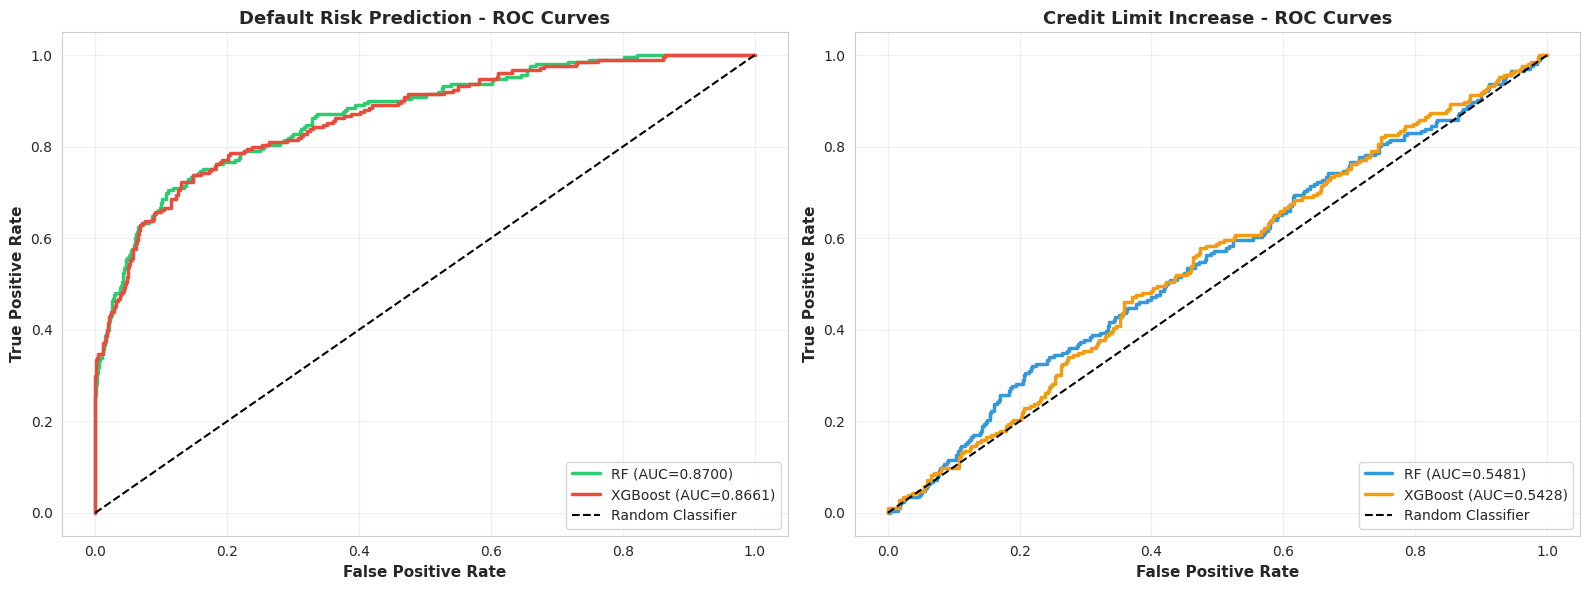

✓ Saved: 04_Precision_Recall_Curves.png


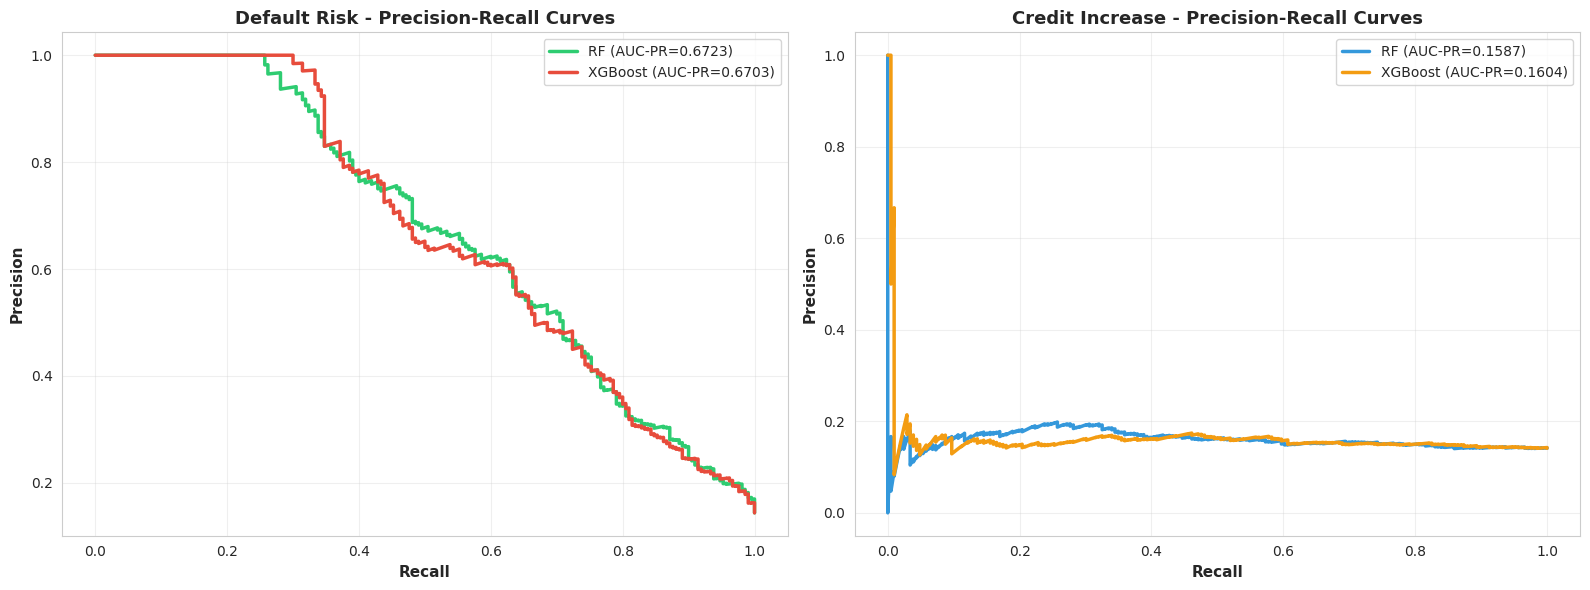

✓ Saved: 05_Feature_Importance_Default.png


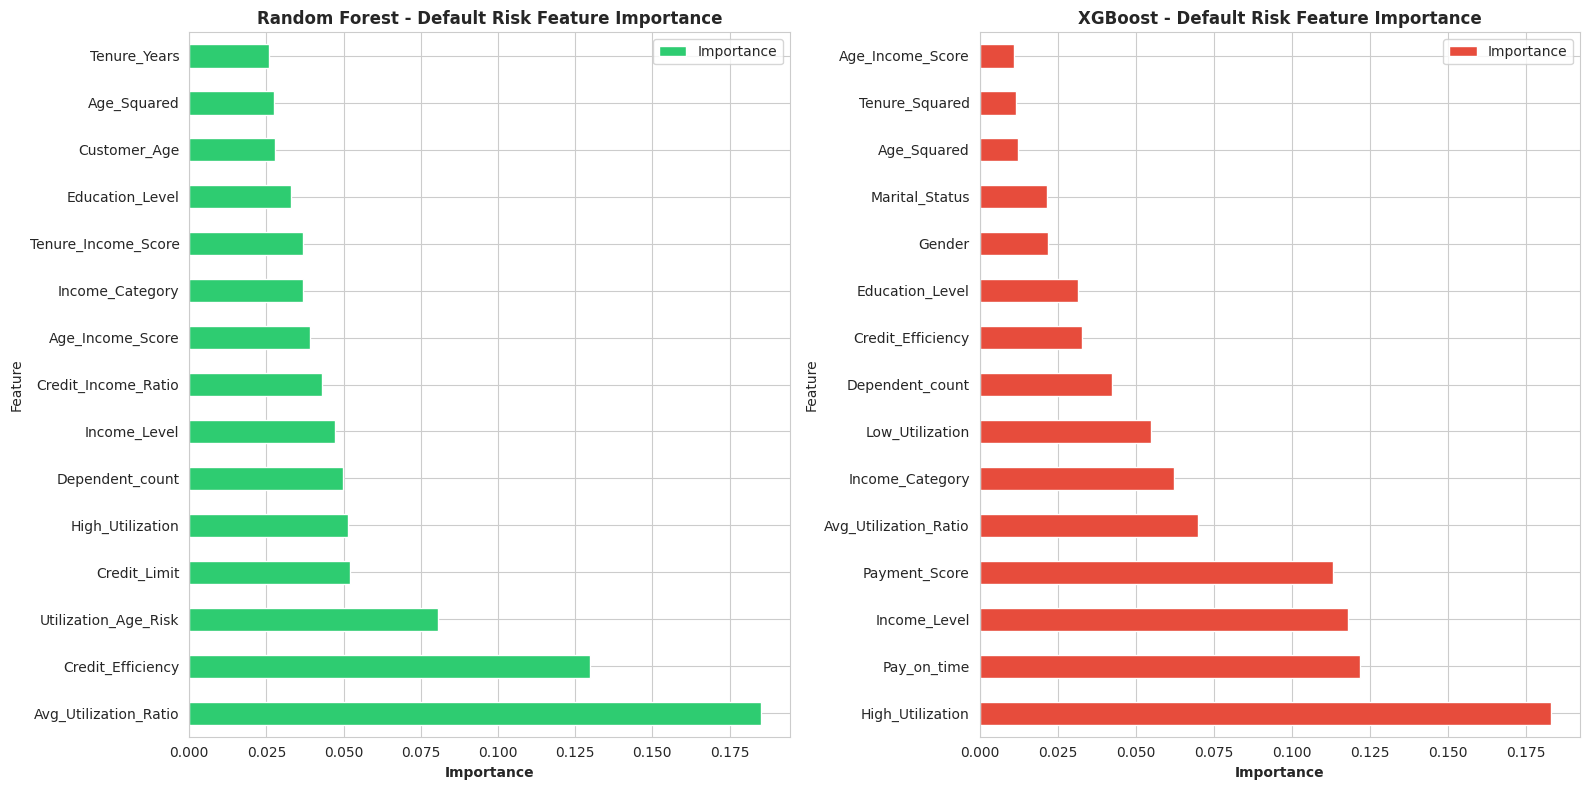

✓ Saved: 06_Feature_Importance_Increase.png


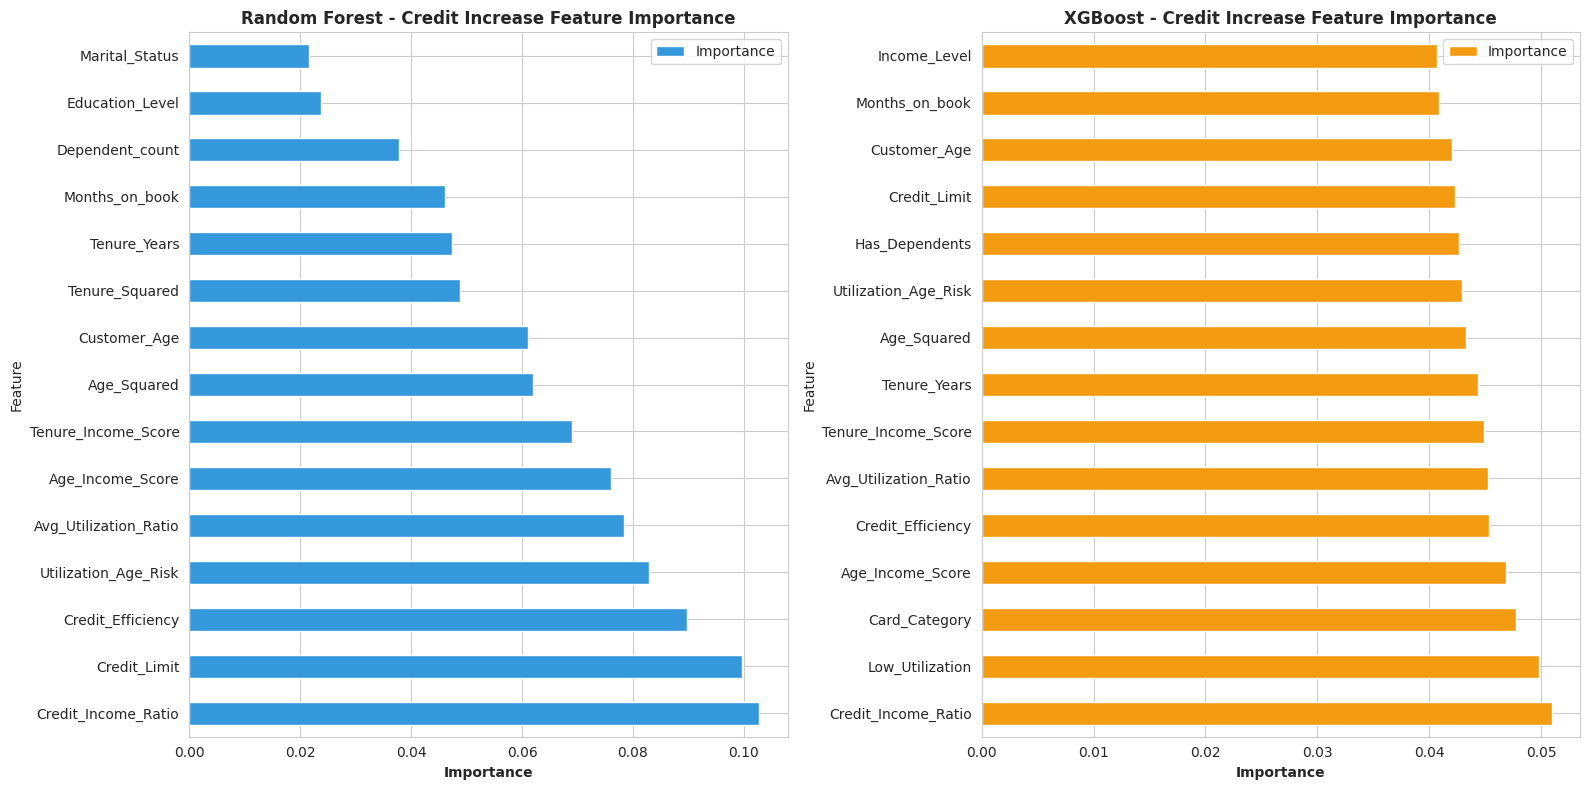

✓ Saved: 07_SMOTE_Effect.png


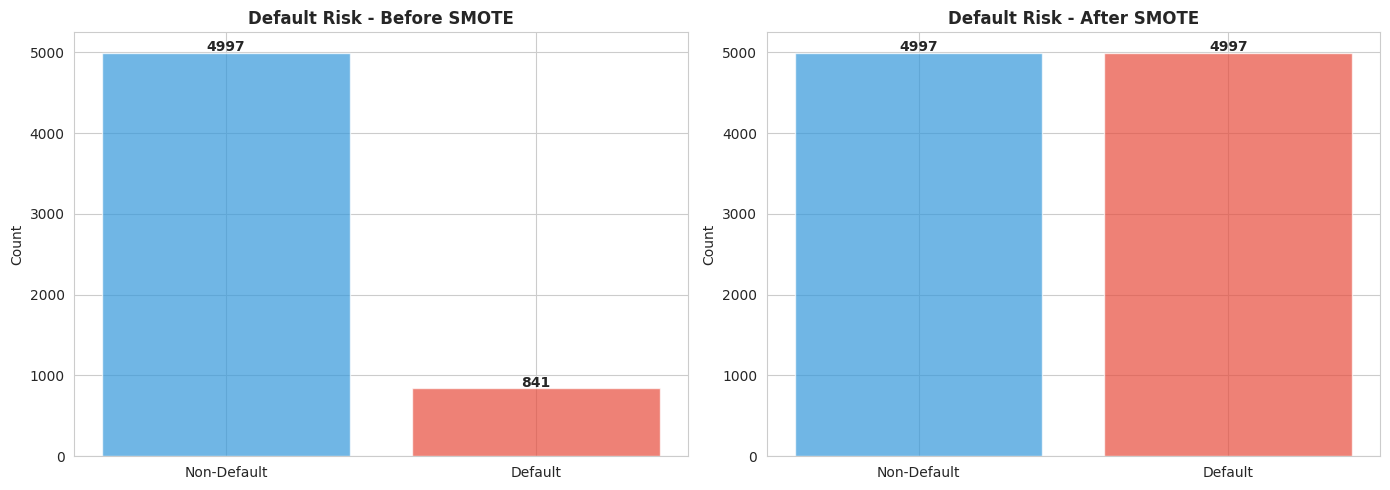

✓ Saved: 08_Probability_Distributions.png


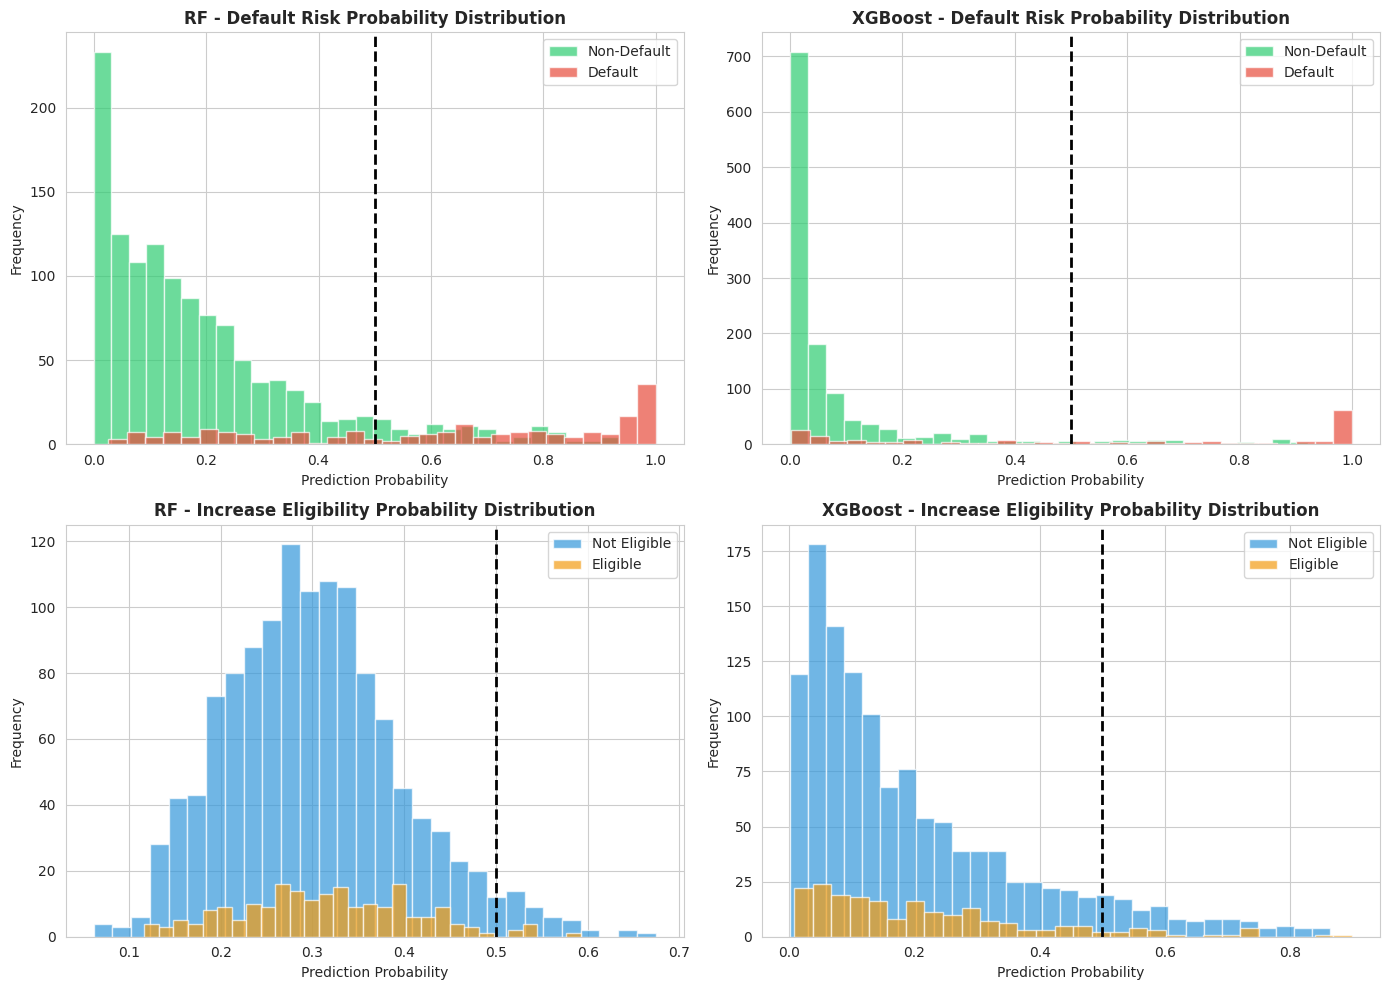


[14] GENERATING PREDICTIONS FOR ALL CUSTOMERS...

--- HIGH DEFAULT RISK CUSTOMERS (Top 20) ---
 Customer_Age Income_Category  Credit_Limit  Avg_Utilization  Default_Risk_Ensemble Default_Risk_Category
           37        31 – 50k        2523.0            0.983               0.999872                  High
           36            <30k        2835.0            0.886               0.999820                  High
           45            <30k        2551.0            0.883               0.999702                  High
           45            <30k        2330.0            0.985               0.999698                  High
           46            <30k        1555.0            0.878               0.999686                  High
           46            <30k        2503.0            0.948               0.999655                  High
           54            <30k        2737.0            0.920               0.999559                  High
           47            <30k        1776.0            0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score, accuracy_score, auc
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
np.random.seed(42)

print("\n" + "="*90)
print(" " * 15 + "CREDIT CARD ML PIPELINE - GOOGLE COLAB")
print("="*90)

# ============================================================================
# 2. LOAD DATA FROM GOOGLE DRIVE
# ============================================================================

print("\n[1] LOADING DATA FROM GOOGLE DRIVE...")

# Update this path to your actual Google Drive file path
INPUT_CSV = "/content/drive/MyDrive/Credit_limit_optimization/Credit_Card_Dataset.csv"

df = pd.read_csv(INPUT_CSV)

print(f"✓ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nDataset Overview:")
print(f"  - Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  - Missing values: {df.isnull().sum().sum()}")
print(f"  - Duplicate rows: {df.duplicated().sum()}")
print(f"\nFirst few rows:")
print(df.head())

# ============================================================================
# 3. DATA CLEANING & PREPROCESSING
# ============================================================================

print("\n[2] DATA CLEANING & PREPROCESSING...")

# Handle missing values
df = df.replace('#NULL!', np.nan)
df['Marital_Status'].fillna(df['Marital_Status'].mode()[0], inplace=True)
df['Income_Category'].fillna(df['Income_Category'].mode()[0], inplace=True)

# Remove unnecessary columns
df.drop(['CLIENTNUM', 'Random_numbers'], axis=1, inplace=True)

print(f"✓ Cleaned dataset shape: {df.shape}")

# ============================================================================
# 4. FEATURE ENGINEERING
# ============================================================================

print("\n[3] FEATURE ENGINEERING...")

df_fe = df.copy()

# A. BEHAVIORAL FEATURES
df_fe['Utilization_Age_Risk'] = df_fe['Avg_Utilization_Ratio'] * (df_fe['Customer_Age'] / 100)
df_fe['Credit_Efficiency'] = df_fe['Credit_Limit'] * df_fe['Avg_Utilization_Ratio']
df_fe['Tenure_Years'] = df_fe['Months_on_book'] / 12
df_fe['Tenure_Squared'] = df_fe['Months_on_book'] ** 2
df_fe['Age_Squared'] = df_fe['Customer_Age'] ** 2

df_fe['Age_Group'] = pd.cut(df_fe['Customer_Age'],
                             bins=[0, 30, 40, 50, 60, 100],
                             labels=['18-30', '31-40', '41-50', '51-60', '60+'])

df_fe['High_Utilization'] = (df_fe['Avg_Utilization_Ratio'] > 0.7).astype(int)
df_fe['Low_Utilization'] = (df_fe['Avg_Utilization_Ratio'] < 0.1).astype(int)

df_fe['Utilization_Bucket'] = pd.cut(df_fe['Avg_Utilization_Ratio'],
                                      bins=[0, 0.25, 0.5, 0.75, 1.0],
                                      labels=['Very_Low', 'Low', 'Medium', 'High'])

# Income level mapping
income_map = {'<30k': 1, '31 – 50k': 2, '51 – 70k': 3, '71 – 110k': 4, '111k+': 5}
df_fe['Income_Level'] = df_fe['Income_Category'].map(income_map)

# Binary features
df_fe['Payment_Score'] = (df_fe['Pay_on_time'] == 'yes').astype(int)
df_fe['Has_Dependents'] = (df_fe['Dependent_count'] > 0).astype(int)
df_fe['Premium_Card'] = (df_fe['Card_Category'] == 'gold').astype(int)

# Interaction features
df_fe['Credit_Income_Ratio'] = df_fe['Credit_Limit'] / (df_fe['Income_Level'] * 10000)
df_fe['Payment_Utilization_Risk'] = df_fe['Payment_Score'] * df_fe['Avg_Utilization_Ratio']
df_fe['Age_Income_Score'] = (df_fe['Customer_Age'] / 100) * df_fe['Income_Level']
df_fe['Tenure_Income_Score'] = df_fe['Tenure_Years'] * df_fe['Income_Level']

print(f"✓ Created {len([col for col in df_fe.columns if col not in df.columns])} new features")
print(f"  Total features: {df_fe.shape[1]}")

# ============================================================================
# 5. TARGET VARIABLE ENGINEERING
# ============================================================================

print("\n[4] TARGET VARIABLE ENGINEERING...")

# TARGET 1: DEFAULT RISK (based on multiple risk factors)
df_fe['Default_Risk_Score'] = (
    (df_fe['Attrition_Flag'] == 'yes').astype(int) * 0.4 +
    (df_fe['Avg_Utilization_Ratio'] > 0.8).astype(int) * 0.3 +
    ((df_fe['Pay_on_time'] == 'no').astype(int)) * 0.2 +
    (df_fe['Income_Level'] == 1).astype(int) * 0.1
)

df_fe['Default_Likely'] = (df_fe['Default_Risk_Score'] > 0.4).astype(int)

# TARGET 2: CREDIT LIMIT INCREASE ELIGIBILITY
df_fe['Increase_Eligible'] = (
    (df_fe['Pay_on_time'] == 'yes').astype(int) &
    (df_fe['Avg_Utilization_Ratio'] < 0.5).astype(int) &
    (df_fe['Months_on_book'] > 24).astype(int) &
    (df_fe['Attrition_Flag'] == 'no').astype(int)
).astype(int)

print(f"\nTarget Distribution:")
print(f"  Default Risk:")
print(f"    {(df_fe['Default_Likely'] == 0).sum()} Non-Default ({(df_fe['Default_Likely'] == 0).sum()/len(df_fe)*100:.2f}%)")
print(f"    {(df_fe['Default_Likely'] == 1).sum()} Default ({(df_fe['Default_Likely'] == 1).sum()/len(df_fe)*100:.2f}%)")

print(f"\n  Increase Eligibility:")
print(f"    {(df_fe['Increase_Eligible'] == 0).sum()} Not Eligible ({(df_fe['Increase_Eligible'] == 0).sum()/len(df_fe)*100:.2f}%)")
print(f"    {(df_fe['Increase_Eligible'] == 1).sum()} Eligible ({(df_fe['Increase_Eligible'] == 1).sum()/len(df_fe)*100:.2f}%)")

# ============================================================================
# 6. PREPARE FEATURES FOR MODELING
# ============================================================================

print("\n[5] PREPARING FEATURES FOR MODELING...")

# Identify all categorical columns
categorical_features = df_fe.select_dtypes(include=['object']).columns.tolist()
# Remove target columns
categorical_features = [col for col in categorical_features
                        if col not in ['Attrition_Flag', 'Default_Likely', 'Increase_Eligible',
                                      'Default_Risk_Score']]

# Encode categorical variables
df_encoded = df_fe.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# Select final numerical features (exclude targets and non-numeric)
X_features = [col for col in df_encoded.columns
              if col not in ['Attrition_Flag', 'Default_Likely', 'Increase_Eligible',
                            'Default_Risk_Score', 'Age_Group', 'Utilization_Bucket']]

X = df_encoded[X_features]
y_default = df_encoded['Default_Likely']
y_increase = df_encoded['Increase_Eligible']

print(f"✓ Final feature matrix shape: {X.shape}")
print(f"  Features: {X.shape[1]}")
print(f"\nFeature list: {X_features}")

# ============================================================================
# 7. SPLIT DATA
# ============================================================================

print("\n[6] SPLITTING DATA...")

X_train, X_test, y_default_train, y_default_test = train_test_split(
    X, y_default, test_size=0.2, random_state=42, stratify=y_default
)

_, _, y_increase_train, y_increase_test = train_test_split(
    X, y_increase, test_size=0.2, random_state=42, stratify=y_increase
)

print(f"✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")
print(f"  Train-Test Split: 80-20")

# ============================================================================
# 8. SCALE FEATURES
# ============================================================================

print("\n[7] SCALING FEATURES...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Features scaled using StandardScaler")

# ============================================================================
# 9. SMOTE - HANDLE CLASS IMBALANCE (DEFAULT RISK ONLY)
# ============================================================================

print("\n[8] APPLYING SMOTE FOR CLASS BALANCE (Default Risk)...")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_default_train)

print(f"\n✓ Default Risk - After SMOTE:")
print(f"  Non-Default: {(y_train_smote == 0).sum()}")
print(f"  Default: {(y_train_smote == 1).sum()}")
print(f"  Balance ratio: {(y_train_smote == 1).sum() / (y_train_smote == 0).sum():.2f}")

# ============================================================================
# 10. RANDOM FOREST MODELS
# ============================================================================

print("\n[9] TRAINING RANDOM FOREST MODELS...")

print("\n--- DEFAULT RISK PREDICTION ---")
rf_default = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_default.fit(X_train_smote, y_train_smote)

y_pred_rf_default = rf_default.predict(X_test_scaled)
y_pred_rf_default_proba = rf_default.predict_proba(X_test_scaled)[:, 1]

rf_default_acc = accuracy_score(y_default_test, y_pred_rf_default)
rf_default_f1 = f1_score(y_default_test, y_pred_rf_default)
rf_default_auc = roc_auc_score(y_default_test, y_pred_rf_default_proba)

print(f"✓ Random Forest Default Model:")
print(f"  Accuracy: {rf_default_acc:.4f}")
print(f"  F1-Score: {rf_default_f1:.4f}")
print(f"  ROC-AUC: {rf_default_auc:.4f}")
print(f"\n  Classification Report:")
print(classification_report(y_default_test, y_pred_rf_default,
                          target_names=['Non-Default', 'Default']))

print("\n--- CREDIT LIMIT INCREASE PREDICTION ---")

rf_increase = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_increase.fit(X_train_scaled, y_increase_train)

y_pred_rf_increase = rf_increase.predict(X_test_scaled)
y_pred_rf_increase_proba = rf_increase.predict_proba(X_test_scaled)[:, 1]

rf_increase_acc = accuracy_score(y_increase_test, y_pred_rf_increase)
rf_increase_f1 = f1_score(y_increase_test, y_pred_rf_increase)
rf_increase_auc = roc_auc_score(y_increase_test, y_pred_rf_increase_proba)

print(f"✓ Random Forest Increase Model:")
print(f"  Accuracy: {rf_increase_acc:.4f}")
print(f"  F1-Score: {rf_increase_f1:.4f}")
print(f"  ROC-AUC: {rf_increase_auc:.4f}")
print(f"\n  Classification Report:")
print(classification_report(y_increase_test, y_pred_rf_increase,
                          target_names=['Not Eligible', 'Eligible']))

# ============================================================================
# 11. XGBOOST MODELS
# ============================================================================

print("\n[10] TRAINING XGBOOST MODELS...")

print("\n--- DEFAULT RISK PREDICTION ---")

xgb_default = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=(y_train_smote == 0).sum() / (y_train_smote == 1).sum()
)

xgb_default.fit(X_train_smote, y_train_smote, verbose=False)

y_pred_xgb_default = xgb_default.predict(X_test_scaled)
y_pred_xgb_default_proba = xgb_default.predict_proba(X_test_scaled)[:, 1]

xgb_default_acc = accuracy_score(y_default_test, y_pred_xgb_default)
xgb_default_f1 = f1_score(y_default_test, y_pred_xgb_default)
xgb_default_auc = roc_auc_score(y_default_test, y_pred_xgb_default_proba)

print(f"✓ XGBoost Default Model:")
print(f"  Accuracy: {xgb_default_acc:.4f}")
print(f"  F1-Score: {xgb_default_f1:.4f}")
print(f"  ROC-AUC: {xgb_default_auc:.4f}")
print(f"\n  Classification Report:")
print(classification_report(y_default_test, y_pred_xgb_default,
                          target_names=['Non-Default', 'Default']))

print("\n--- CREDIT LIMIT INCREASE PREDICTION ---")

xgb_increase = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=(y_increase_train == 0).sum() / (y_increase_train == 1).sum()
)

xgb_increase.fit(X_train_scaled, y_increase_train, verbose=False)

y_pred_xgb_increase = xgb_increase.predict(X_test_scaled)
y_pred_xgb_increase_proba = xgb_increase.predict_proba(X_test_scaled)[:, 1]

xgb_increase_acc = accuracy_score(y_increase_test, y_pred_xgb_increase)
xgb_increase_f1 = f1_score(y_increase_test, y_pred_xgb_increase)
xgb_increase_auc = roc_auc_score(y_increase_test, y_pred_xgb_increase_proba)

print(f"✓ XGBoost Increase Model:")
print(f"  Accuracy: {xgb_increase_acc:.4f}")
print(f"  F1-Score: {xgb_increase_f1:.4f}")
print(f"  ROC-AUC: {xgb_increase_auc:.4f}")
print(f"\n  Classification Report:")
print(classification_report(y_increase_test, y_pred_xgb_increase,
                          target_names=['Not Eligible', 'Eligible']))

# ============================================================================
# 12. MODEL COMPARISON
# ============================================================================

print("\n[11] MODEL COMPARISON...")

comparison_default = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [rf_default_acc, xgb_default_acc],
    'F1-Score': [rf_default_f1, xgb_default_f1],
    'ROC-AUC': [rf_default_auc, xgb_default_auc]
})

comparison_increase = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [rf_increase_acc, xgb_increase_acc],
    'F1-Score': [rf_increase_f1, xgb_increase_f1],
    'ROC-AUC': [rf_increase_auc, xgb_increase_auc]
})

print("\nDefault Risk Prediction - Model Comparison:")
print(comparison_default.to_string(index=False))

print("\nCredit Limit Increase - Model Comparison:")
print(comparison_increase.to_string(index=False))

# ============================================================================
# 13. FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n[12] FEATURE IMPORTANCE ANALYSIS...")

rf_default_importance = pd.DataFrame({
    'Feature': X_features,
    'Importance': rf_default.feature_importances_
}).sort_values('Importance', ascending=False)

rf_increase_importance = pd.DataFrame({
    'Feature': X_features,
    'Importance': rf_increase.feature_importances_
}).sort_values('Importance', ascending=False)

xgb_default_importance = pd.DataFrame({
    'Feature': X_features,
    'Importance': xgb_default.feature_importances_
}).sort_values('Importance', ascending=False)

xgb_increase_importance = pd.DataFrame({
    'Feature': X_features,
    'Importance': xgb_increase.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features - Default Risk Prediction (Random Forest):")
print(rf_default_importance.head(10).to_string(index=False))

print("\nTop 10 Features - Default Risk Prediction (XGBoost):")
print(xgb_default_importance.head(10).to_string(index=False))

print("\nTop 10 Features - Credit Limit Increase (Random Forest):")
print(rf_increase_importance.head(10).to_string(index=False))

print("\nTop 10 Features - Credit Limit Increase (XGBoost):")
print(xgb_increase_importance.head(10).to_string(index=False))

# ============================================================================
# 14. VISUALIZATIONS
# ============================================================================

print("\n[13] GENERATING VISUALIZATIONS...")

# Figure 1: Model Performance Comparison
fig1, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics = ['Accuracy', 'F1-Score', 'ROC-AUC']
rf_scores = [rf_default_acc, rf_default_f1, rf_default_auc]
xgb_scores = [xgb_default_acc, xgb_default_f1, xgb_default_auc]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, rf_scores, width, label='Random Forest', color='#2ecc71', alpha=0.8)
axes[0].bar(x + width/2, xgb_scores, width, label='XGBoost', color='#e74c3c', alpha=0.8)
axes[0].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[0].set_title('Default Risk Prediction - Model Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim([0.8, 1.0])
axes[0].grid(axis='y', alpha=0.3)

for i, (rf, xgb_val) in enumerate(zip(rf_scores, xgb_scores)):
    axes[0].text(i - width/2, rf + 0.005, f'{rf:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, xgb_val + 0.005, f'{xgb_val:.3f}', ha='center', va='bottom', fontsize=9)

rf_inc_scores = [rf_increase_acc, rf_increase_f1, rf_increase_auc]
xgb_inc_scores = [xgb_increase_acc, xgb_increase_f1, xgb_increase_auc]

axes[1].bar(x - width/2, rf_inc_scores, width, label='Random Forest', color='#3498db', alpha=0.8)
axes[1].bar(x + width/2, xgb_inc_scores, width, label='XGBoost', color='#f39c12', alpha=0.8)
axes[1].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[1].set_title('Credit Limit Increase - Model Comparison', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim([0.8, 1.0])
axes[1].grid(axis='y', alpha=0.3)

for i, (rf, xgb_val) in enumerate(zip(rf_inc_scores, xgb_inc_scores)):
    axes[1].text(i - width/2, rf + 0.005, f'{rf:.3f}', ha='center', va='bottom', fontsize=9)
    axes[1].text(i + width/2, xgb_val + 0.005, f'{xgb_val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Credit_limit_optimization/01_Model_Comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 01_Model_Comparison.png")
plt.show()

# Figure 2: Confusion Matrices
fig2, axes = plt.subplots(2, 2, figsize=(14, 12))

cm_rf_default = confusion_matrix(y_default_test, y_pred_rf_default)
sns.heatmap(cm_rf_default, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
axes[0, 0].set_title('RF - Default Risk Prediction', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontweight='bold')

cm_xgb_default = confusion_matrix(y_default_test, y_pred_xgb_default)
sns.heatmap(cm_xgb_default, annot=True, fmt='d', cmap='Reds', ax=axes[0, 1],
            xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
axes[0, 1].set_title('XGBoost - Default Risk Prediction', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Actual', fontweight='bold')

cm_rf_increase = confusion_matrix(y_increase_test, y_pred_rf_increase)
sns.heatmap(cm_rf_increase, annot=True, fmt='d', cmap='Greens', ax=axes[1, 0],
            xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
axes[1, 0].set_title('RF - Credit Increase Eligibility', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Actual', fontweight='bold')

cm_xgb_increase = confusion_matrix(y_increase_test, y_pred_xgb_increase)
sns.heatmap(cm_xgb_increase, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 1],
            xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
axes[1, 1].set_title('XGBoost - Credit Increase Eligibility', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Actual', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Credit_limit_optimization/02_Confusion_Matrices.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 02_Confusion_Matrices.png")
plt.show()

# Figure 3: ROC Curves
fig3, axes = plt.subplots(1, 2, figsize=(16, 6))

fpr_rf, tpr_rf, _ = roc_curve(y_default_test, y_pred_rf_default_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_default_test, y_pred_xgb_default_proba)

axes[0].plot(fpr_rf, tpr_rf, label=f'RF (AUC={rf_default_auc:.4f})', linewidth=2.5, color='#2ecc71')
axes[0].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={xgb_default_auc:.4f})', linewidth=2.5, color='#e74c3c')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
axes[0].set_title('Default Risk Prediction - ROC Curves', fontsize=13, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)

fpr_rf_inc, tpr_rf_inc, _ = roc_curve(y_increase_test, y_pred_rf_increase_proba)
fpr_xgb_inc, tpr_xgb_inc, _ = roc_curve(y_increase_test, y_pred_xgb_increase_proba)

axes[1].plot(fpr_rf_inc, tpr_rf_inc, label=f'RF (AUC={rf_increase_auc:.4f})', linewidth=2.5, color='#3498db')
axes[1].plot(fpr_xgb_inc, tpr_xgb_inc, label=f'XGBoost (AUC={xgb_increase_auc:.4f})', linewidth=2.5, color='#f39c12')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
axes[1].set_title('Credit Limit Increase - ROC Curves', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Credit_limit_optimization/03_ROC_Curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 03_ROC_Curves.png")
plt.show()

# Figure 4: Precision-Recall Curves
fig4, axes = plt.subplots(1, 2, figsize=(16, 6))

prec_rf, rec_rf, _ = precision_recall_curve(y_default_test, y_pred_rf_default_proba)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_default_test, y_pred_xgb_default_proba)

auc_rf_pr = auc(rec_rf, prec_rf)
auc_xgb_pr = auc(rec_xgb, prec_xgb)

axes[0].plot(rec_rf, prec_rf, label=f'RF (AUC-PR={auc_rf_pr:.4f})', linewidth=2.5, color='#2ecc71')
axes[0].plot(rec_xgb, prec_xgb, label=f'XGBoost (AUC-PR={auc_xgb_pr:.4f})', linewidth=2.5, color='#e74c3c')
axes[0].set_xlabel('Recall', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Precision', fontsize=11, fontweight='bold')
axes[0].set_title('Default Risk - Precision-Recall Curves', fontsize=13, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(alpha=0.3)

prec_rf_inc, rec_rf_inc, _ = precision_recall_curve(y_increase_test, y_pred_rf_increase_proba)
prec_xgb_inc, rec_xgb_inc, _ = precision_recall_curve(y_increase_test, y_pred_xgb_increase_proba)

auc_rf_inc_pr = auc(rec_rf_inc, prec_rf_inc)
auc_xgb_inc_pr = auc(rec_xgb_inc, prec_xgb_inc)

axes[1].plot(rec_rf_inc, prec_rf_inc, label=f'RF (AUC-PR={auc_rf_inc_pr:.4f})', linewidth=2.5, color='#3498db')
axes[1].plot(rec_xgb_inc, prec_xgb_inc, label=f'XGBoost (AUC-PR={auc_xgb_inc_pr:.4f})', linewidth=2.5, color='#f39c12')
axes[1].set_xlabel('Recall', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=11, fontweight='bold')
axes[1].set_title('Credit Increase - Precision-Recall Curves', fontsize=13, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Credit_limit_optimization/04_Precision_Recall_Curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 04_Precision_Recall_Curves.png")
plt.show()

# Figure 5: Feature Importance - Default Risk
fig5, axes = plt.subplots(1, 2, figsize=(16, 8))

rf_default_importance.head(15).plot(x='Feature', y='Importance', kind='barh', ax=axes[0], color='#2ecc71')
axes[0].set_title('Random Forest - Default Risk Feature Importance', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance', fontweight='bold')

xgb_default_importance.head(15).plot(x='Feature', y='Importance', kind='barh', ax=axes[1], color='#e74c3c')
axes[1].set_title('XGBoost - Default Risk Feature Importance', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Credit_limit_optimization/05_Feature_Importance_Default.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 05_Feature_Importance_Default.png")
plt.show()

# Figure 6: Feature Importance - Credit Increase
fig6, axes = plt.subplots(1, 2, figsize=(16, 8))

rf_increase_importance.head(15).plot(x='Feature', y='Importance', kind='barh', ax=axes[0], color='#3498db')
axes[0].set_title('Random Forest - Credit Increase Feature Importance', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance', fontweight='bold')

xgb_increase_importance.head(15).plot(x='Feature', y='Importance', kind='barh', ax=axes[1], color='#f39c12')
axes[1].set_title('XGBoost - Credit Increase Feature Importance', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Credit_limit_optimization/06_Feature_Importance_Increase.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 06_Feature_Importance_Increase.png")
plt.show()

# Figure 7: Class Distribution - Before & After SMOTE
fig7, axes = plt.subplots(1, 2, figsize=(14, 5))

before_default = pd.Series(y_default_train).value_counts()
axes[0].bar(['Non-Default', 'Default'], [before_default[0], before_default[1]],
            color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0].set_title('Default Risk - Before SMOTE', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate([before_default[0], before_default[1]]):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

after_default = pd.Series(y_train_smote).value_counts()
axes[1].bar(['Non-Default', 'Default'], [after_default[0], after_default[1]],
            color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1].set_title('Default Risk - After SMOTE', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count')
for i, v in enumerate([after_default[0], after_default[1]]):
    axes[1].text(i, v + 20, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Credit_limit_optimization/07_SMOTE_Effect.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 07_SMOTE_Effect.png")
plt.show()

# Figure 8: Prediction Probability Distribution
fig8, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(y_pred_rf_default_proba[y_default_test == 0], bins=30, alpha=0.7, label='Non-Default', color='#2ecc71')
axes[0, 0].hist(y_pred_rf_default_proba[y_default_test == 1], bins=30, alpha=0.7, label='Default', color='#e74c3c')
axes[0, 0].set_title('RF - Default Risk Probability Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Prediction Probability')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].axvline(x=0.5, color='black', linestyle='--', linewidth=2)

axes[0, 1].hist(y_pred_xgb_default_proba[y_default_test == 0], bins=30, alpha=0.7, label='Non-Default', color='#2ecc71')
axes[0, 1].hist(y_pred_xgb_default_proba[y_default_test == 1], bins=30, alpha=0.7, label='Default', color='#e74c3c')
axes[0, 1].set_title('XGBoost - Default Risk Probability Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Prediction Probability')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2)

axes[1, 0].hist(y_pred_rf_increase_proba[y_increase_test == 0], bins=30, alpha=0.7, label='Not Eligible', color='#3498db')
axes[1, 0].hist(y_pred_rf_increase_proba[y_increase_test == 1], bins=30, alpha=0.7, label='Eligible', color='#f39c12')
axes[1, 0].set_title('RF - Increase Eligibility Probability Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Prediction Probability')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', linewidth=2)

axes[1, 1].hist(y_pred_xgb_increase_proba[y_increase_test == 0], bins=30, alpha=0.7, label='Not Eligible', color='#3498db')
axes[1, 1].hist(y_pred_xgb_increase_proba[y_increase_test == 1], bins=30, alpha=0.7, label='Eligible', color='#f39c12')
axes[1, 1].set_title('XGBoost - Increase Eligibility Probability Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Prediction Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Credit_limit_optimization/08_Probability_Distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 08_Probability_Distributions.png")
plt.show()

# ============================================================================
# 15. GENERATE PREDICTIONS FOR ALL CUSTOMERS
# ============================================================================

print("\n[14] GENERATING PREDICTIONS FOR ALL CUSTOMERS...")

X_all = df_encoded[X_features]
X_all_scaled = scaler.transform(X_all)

pred_default_rf = rf_default.predict_proba(X_all_scaled)[:, 1]
pred_default_xgb = xgb_default.predict_proba(X_all_scaled)[:, 1]

pred_increase_rf = rf_increase.predict_proba(X_all_scaled)[:, 1]
pred_increase_xgb = xgb_increase.predict_proba(X_all_scaled)[:, 1]

results_df = pd.DataFrame({
    'Customer_Age': df['Customer_Age'].values,
    'Income_Category': df['Income_Category'].values,
    'Gender': df['Gender'].values,
    'Card_Category': df['Card_Category'].values,
    'Credit_Limit': df['Credit_Limit'].values,
    'Avg_Utilization': df['Avg_Utilization_Ratio'].values,
    'Pay_on_Time': df['Pay_on_time'].values,
    'Default_Risk_RF': pred_default_rf,
    'Default_Risk_XGB': pred_default_xgb,
    'Default_Risk_Ensemble': (pred_default_rf + pred_default_xgb) / 2,
    'Increase_Eligible_RF': pred_increase_rf,
    'Increase_Eligible_XGB': pred_increase_xgb,
    'Increase_Eligible_Ensemble': (pred_increase_rf + pred_increase_xgb) / 2,
})

results_df['Default_Risk_Category'] = pd.cut(results_df['Default_Risk_Ensemble'],
                                              bins=[0, 0.3, 0.6, 1.0],
                                              labels=['Low', 'Medium', 'High'])

results_df['Increase_Recommendation'] = results_df['Increase_Eligible_Ensemble'].apply(
    lambda x: 'Strong' if x > 0.7 else ('Moderate' if x > 0.4 else 'Not Recommended')
)

# Save to Google Drive
print("\n--- HIGH DEFAULT RISK CUSTOMERS (Top 20) ---")
high_risk = results_df.nlargest(20, 'Default_Risk_Ensemble')[
    ['Customer_Age', 'Income_Category', 'Credit_Limit', 'Avg_Utilization',
     'Default_Risk_Ensemble', 'Default_Risk_Category']
]
print(high_risk.to_string(index=False))

print("\n--- HIGH INCREASE ELIGIBILITY CUSTOMERS (Top 20) ---")
high_eligible = results_df.nlargest(20, 'Increase_Eligible_Ensemble')[
    ['Customer_Age', 'Income_Category', 'Credit_Limit', 'Avg_Utilization',
     'Increase_Eligible_Ensemble', 'Increase_Recommendation']
]
print(high_eligible.to_string(index=False))

# Save results to Google Drive
results_df.to_csv('/content/drive/MyDrive/Credit_limit_optimization/Customer_Predictions.csv', index=False)
print("\n✓ Saved: Customer_Predictions.csv")

high_risk.to_csv('/content/drive/MyDrive/Credit_limit_optimization/High_Default_Risk_Customers.csv', index=False)
print("✓ Saved: High_Default_Risk_Customers.csv")

high_eligible.to_csv('/content/drive/MyDrive/Credit_limit_optimization/High_Increase_Eligible_Customers.csv', index=False)
print("✓ Saved: High_Increase_Eligible_Customers.csv")

# ============================================================================
# 16. FINAL SUMMARY
# ============================================================================

print("\n" + "="*90)
print(" " * 30 + "ANALYSIS SUMMARY")
print("="*90)

print(f"""
DATASET & FEATURE ENGINEERING:
  • Total Customers Analyzed: {len(df):,}
  • Original Features: {df.shape[1]}
  • Engineered Features: {len(X_features)}

CLASS IMBALANCE HANDLING:
  • SMOTE Applied for Default Risk Training
  • Original Default Ratio: {(y_default_train == 1).sum() / len(y_default_train):.1%}
  • After SMOTE: 50-50 balanced

DEFAULT RISK PREDICTION - BEST MODEL:
  • Best Model: {'XGBoost' if xgb_default_auc > rf_default_auc else 'Random Forest'}
  • Accuracy: {max(xgb_default_acc, rf_default_acc):.4f}
  • ROC-AUC: {max(xgb_default_auc, rf_default_auc):.4f}
  • F1-Score: {max(xgb_default_f1, rf_default_f1):.4f}

CREDIT LIMIT INCREASE - BEST MODEL:
  • Best Model: {'XGBoost' if xgb_increase_auc > rf_increase_auc else 'Random Forest'}
  • Accuracy: {max(xgb_increase_acc, rf_increase_acc):.4f}
  • ROC-AUC: {max(xgb_increase_auc, rf_increase_auc):.4f}
  • F1-Score: {max(xgb_increase_f1, rf_increase_f1):.4f}

CUSTOMER SEGMENTATION:
  • High Default Risk (>0.6): {(results_df['Default_Risk_Ensemble'] > 0.6).sum():,} customers
  • Medium Default Risk (0.3-0.6): {((results_df['Default_Risk_Ensemble'] >= 0.3) & (results_df['Default_Risk_Ensemble'] <= 0.6)).sum():,} customers
  • Low Default Risk (<0.3): {(results_df['Default_Risk_Ensemble'] < 0.3).sum():,} customers

  • Strong Increase Eligible (>0.7): {(results_df['Increase_Eligible_Ensemble'] > 0.7).sum():,} customers
  • Moderate Increase Eligible (0.4-0.7): {((results_df['Increase_Eligible_Ensemble'] >= 0.4) & (results_df['Increase_Eligible_Ensemble'] <= 0.7)).sum():,} customers
  • Not Recommended (<0.4): {(results_df['Increase_Eligible_Ensemble'] < 0.4).sum():,} customers

OUTPUT FILES GENERATED:
  ✓ 8 Visualization Files (.png)
  ✓ Customer_Predictions.csv - All predictions with probabilities
  ✓ High_Default_Risk_Customers.csv - Top 20 default risk customers
  ✓ High_Increase_Eligible_Customers.csv - Top 20 increase eligible customers
""")

print("="*90)
print(" " * 25 + "✓ ML PIPELINE EXECUTION COMPLETE")
print("="*90 + "\n")